In [24]:
############# Initialisation ################

rm(list=ls())
shhh <- suppressPackageStartupMessages

shhh(library(tidyquant))
shhh(library(timetk))
shhh(library(tibbletime))
shhh(library(PerformanceAnalytics))
shhh(library(blotter))
shhh(library(quantstrat))

set.seed(1234)

In [25]:
################# Setting up the data ##################################################
# This data was taken from Bloomberg terminal - May 2019

data <- read.delim("E:/trading_model/data/XBTUSD.csv", sep = ";", stringsAsFactors = FALSE)
colnames(data)[1] <- "Dates"

head(data)

Dates,Open,Close,High,Low,Value,Volume,Number.Ticks
06/06/2019 16:43,7692.69,7687.31,7692.69,7687.26,0,0,373
06/06/2019 16:42,7687.55,7692.68,7692.94,7686.02,0,0,407
06/06/2019 16:41,7692.35,7687.55,7692.55,7687.55,0,0,310
06/06/2019 16:40,7695.89,7692.33,7696.04,7691.27,0,0,434
06/06/2019 16:39,7698.32,7695.89,7702.20,7695.88,0,0,370
06/06/2019 16:38,7703.03,7698.32,7703.33,7698.32,0,0,279


In [26]:
data <- data %>%
  mutate(Dates = ifelse(nchar(Dates) == 10, paste(Dates, "0:00", sep = " "), Dates),
         Dates = as.POSIXct(Dates, format="%d/%m/%Y %H:%M")) %>%
  as_tibble() %>%
  as_tbl_time(Dates)

head(data)

Dates,Open,Close,High,Low,Value,Volume,Number.Ticks
2019-06-06 16:43:00,7692.69,7687.31,7692.69,7687.26,0,0,373
2019-06-06 16:42:00,7687.55,7692.68,7692.94,7686.02,0,0,407
2019-06-06 16:41:00,7692.35,7687.55,7692.55,7687.55,0,0,310
2019-06-06 16:40:00,7695.89,7692.33,7696.04,7691.27,0,0,434
2019-06-06 16:39:00,7698.32,7695.89,7702.20,7695.88,0,0,370
2019-06-06 16:38:00,7703.03,7698.32,7703.33,7698.32,0,0,279


In [27]:
df <- tk_xts(data, date_var = Dates)

head(df)

Warning message in tk_xts_.data.frame(data = data, select = select, date_var = date_var, :
"Non-numeric columns being dropped: Dates"

                       Open   Close    High     Low Value Volume Number.Ticks
2019-03-01 09:00:00 3809.62 3808.76 3809.98 3808.31     0      0          189
2019-03-01 09:01:00 3808.76 3809.10 3809.19 3807.85     0      0          190
2019-03-01 09:02:00 3809.16 3808.69 3809.19 3808.67     0      0          253
2019-03-01 09:03:00 3808.69 3807.92 3809.21 3807.92     0      0          121
2019-03-01 09:04:00 3807.92 3804.90 3807.92 3804.90     0      0          177
2019-03-01 09:05:00 3804.90 3804.67 3805.15 3804.05     0      0          202

In [28]:
#setting up some initial parameters for the quantstrat trading model
initDate="2019-03-01"
init_equity <- 100
adjustment <- TRUE

.orderqty <- 1
.txnfees <- -0.3

currency('USD')
Sys.setenv(TZ="UTC")

[1] "USD"

In [29]:
####################### Simple Model ##################################

df$direction <- with(df, ifelse(Close >= Open, 1, 0))

#create two basic input variables - lagged
df$rsi <- RSI(df$Close, nFast=14, nSlow = 26, nSig = 9, maType = SMA)
df$momentum <- momentum(df$Close, n = 12)

df <- df[complete.cases(df), ] 
df$direction_fwd <- lag.xts(df$direction, k = -1)

# create a training and test set
train_date <- nrow(df) *0.8
train <- df[1:train_date,]
test <- df[-c(1:train_date),]

tail(train)
head(test)

                       Open   Close    High     Low Value Volume Number.Ticks
2019-05-17 19:09:00 7052.00 7073.89 7077.30 7051.97     0      0          580
2019-05-17 19:10:00 7073.89 7059.98 7073.89 7059.63     0      0          635
2019-05-17 19:11:00 7059.98 7065.32 7066.78 7058.21     0      0          439
2019-05-17 19:12:00 7065.32 7050.65 7065.32 7049.87     0      0          401
2019-05-17 19:13:00 7050.65 7062.01 7063.41 7048.23     0      0          605
2019-05-17 19:14:00 7062.01 7067.95 7072.69 7060.17     0      0          633
                    direction      rsi momentum direction_fwd
2019-05-17 19:09:00         1 47.53122   -28.07             0
2019-05-17 19:10:00         0 37.71151   -50.70             1
2019-05-17 19:11:00         1 39.28530   -28.17             0
2019-05-17 19:12:00         0 33.03566   -41.87             1
2019-05-17 19:13:00         1 40.80070   -55.15             1
2019-05-17 19:14:00         1 43.02266   -34.70             1

                       Open   Close    High     Low Value Volume Number.Ticks
2019-05-17 19:15:00 7066.41 7091.00 7091.00 7066.25     0      0          703
2019-05-17 19:16:00 7091.00 7092.66 7094.33 7083.20     0      0          615
2019-05-17 19:17:00 7092.66 7098.50 7102.95 7089.52     0      0          494
2019-05-17 19:18:00 7098.45 7096.46 7099.54 7089.49     0      0          653
2019-05-17 19:19:00 7096.46 7094.95 7096.46 7091.70     0      0          509
2019-05-17 19:20:00 7094.95 7081.90 7096.34 7080.03     0      0          515
                    direction      rsi momentum direction_fwd
2019-05-17 19:15:00         1 42.50344   -10.99             1
2019-05-17 19:16:00         1 46.90961     7.21             1
2019-05-17 19:17:00         1 48.95390     5.97             0
2019-05-17 19:18:00         0 53.61434    18.22             0
2019-05-17 19:19:00         0 50.82459    26.41             0
2019-05-17 19:20:00         0 51.25773    29.40             0

In [30]:
# Run a simple logistic regression and obtain predicted probabilities
lm.fit <- glm(direction_fwd ~ rsi + momentum, data = train, family = binomial)

summary(lm.fit)


Call:
glm(formula = direction_fwd ~ rsi + momentum, family = binomial, 
    data = train)

Deviance Residuals: 
   Min      1Q  Median      3Q     Max  
-1.735  -1.215   1.113   1.139   1.622  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.0257646  0.0230161  -1.119    0.263    
rsi          0.0022950  0.0004273   5.371 7.81e-08 ***
momentum    -0.0014730  0.0003641  -4.045 5.23e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 112762  on 81463  degrees of freedom
Residual deviance: 112730  on 81461  degrees of freedom
AIC: 112736

Number of Fisher Scoring iterations: 3


In [31]:
# Make the predictions on the test data
pr.lm <- predict(lm.fit, test, type = "response")
test$pred_prob <- pr.lm

In [32]:
# If the predicted probability is > 0.50 then predict the market went "Up", if <= 0.50 then predict the market went "Down"
test$prediction <- ifelse(pr.lm > 0.50, 1, 0)

paste0("Accuracy: ", mean(test$direction_fwd == test$prediction, na.rm = T))

[1] "Accuracy: 0.514559292904493"

In [33]:
# Backtest the strategy
stock("test", currency="USD", multiplier=1)
strategy.st <- portfolio.st <- account.st <- "LogisticRegressionStrategy"
rm.strat(strategy.st)
rm.strat(portfolio.st)
rm.strat(account.st)

initPortf(name = portfolio.st,
          symbols = "test", 
          initDate = initDate, 
          currency = 'USD')

initAcct(name = account.st, 
         portfolios = portfolio.st, 
         initDate = initDate, 
         currency = 'USD',
         initEq = init_equity)


initOrders(portfolio.st,
           symbols = "test",
           initDate = initDate)

strategy(strategy.st, store = TRUE)

nMult_orderqty <- 2
addPosLimit(portfolio.st, symbol = "test", timestamp = initDate, maxpos = nMult_orderqty * .orderqty)

[1] "test"

[1] "LogisticRegressionStrategy"

[1] "LogisticRegressionStrategy"

In [34]:
########## Add the buy and sell signals generated from the Logistic Model ############

# Buy when prob exceeds 0.50 for the first time, using cross= TRUE
add.signal(strategy = strategy.st,
           name = "sigThreshold",
           arguments = list(threshold = 0.50, column = "pred_prob", relationship = "gt", cross = TRUE),
           label = "longSig")

# Exit when prob drops below 0.5 for the first time
add.signal(strategy = strategy.st,
           name = "sigThreshold",
           arguments = list(threshold=0.50, column = "pred_prob", relationship = "lte", cross= TRUE),
           label = "exitLongSig")

[1] "LogisticRegressionStrategy"

[1] "LogisticRegressionStrategy"

In [35]:
# Adding the rules, enter at the low price when "prediction" = 1, taking transaction fees into account
add.rule(strategy = strategy.st,
         name = "ruleSignal",
         arguments = list(sigcol = "longSig",
                          sigval = 1,
                          orderqty = .orderqty,
                          ordertype = "market",
                          orderside = "long",
                          osFUN = osMaxPos,
                          prefer = "Open",  #Never kknow the low in advance. Use the open, as it is for the next day (be aware that the open price for bar data has its own problems too)
                          TxnFees = .txnfees, 
                          replace = FALSE),
         type = "enter",
         label = "EnterLONG")

# As soon as the Logistic regression predicts a "0" we dump all our shares 

add.rule(strategy.st, 
         name = "ruleSignal", 
         arguments = list(sigcol = "exitLongSig", 
                          sigval = 1, 
                          ordertype = "market", 
                          orderside = "long",
                          orderqty = "all", 
                          TxnFees = .txnfees, 
                          replace = TRUE), 
         type = "exit", 
         label = "Exit2SHORT")


[1] "LogisticRegressionStrategy"

[1] "LogisticRegressionStrategy"

In [36]:
# Apply the strategy and update the portfolios

applyStrategy(strategy.st, portfolios = portfolio.st)

updatePortf(portfolio.st)
updateAcct(account.st)
updateEndEq(account.st)

[1] "2019-05-17 20:20:00 test 1 @ 7103.96"
[1] "2019-05-19 21:00:00 test -1 @ 7990.1"
[1] "2019-05-19 21:12:00 test 1 @ 7982.39"
[1] "2019-05-20 00:40:00 test -1 @ 8148.97"
[1] "2019-05-20 00:41:00 test 1 @ 8148.97"
[1] "2019-05-20 00:42:00 test -1 @ 8204.98"
[1] "2019-05-20 00:48:00 test 1 @ 8206.54"
[1] "2019-05-20 02:18:00 test -1 @ 8123.08"
[1] "2019-05-20 02:20:00 test 1 @ 8124.05"
[1] "2019-05-20 02:57:00 test -1 @ 7934.93"
[1] "2019-05-20 02:59:00 test 1 @ 7933.11"
[1] "2019-05-20 09:22:00 test -1 @ 7992.57"
[1] "2019-05-20 09:26:00 test 1 @ 7984.62"
[1] "2019-05-20 11:02:00 test -1 @ 7941.87"
[1] "2019-05-20 11:05:00 test 1 @ 7891.13"
[1] "2019-05-20 15:22:00 test -1 @ 7718"
[1] "2019-05-20 15:23:00 test 1 @ 7718"
[1] "2019-05-20 22:47:00 test -1 @ 7966.08"
[1] "2019-05-20 22:49:00 test 1 @ 7958.3"
[1] "2019-05-20 22:50:00 test -1 @ 7961.72"
[1] "2019-05-20 22:53:00 test 1 @ 7965.2"
[1] "2019-05-20 23:03:00 test -1 @ 8089.5"
[1] "2019-05-20 23:05:00 test 1 @ 8067.5"
[1] "2019-0

[1] "LogisticRegressionStrategy"

[1] "LogisticRegressionStrategy"

[1] "LogisticRegressionStrategy"

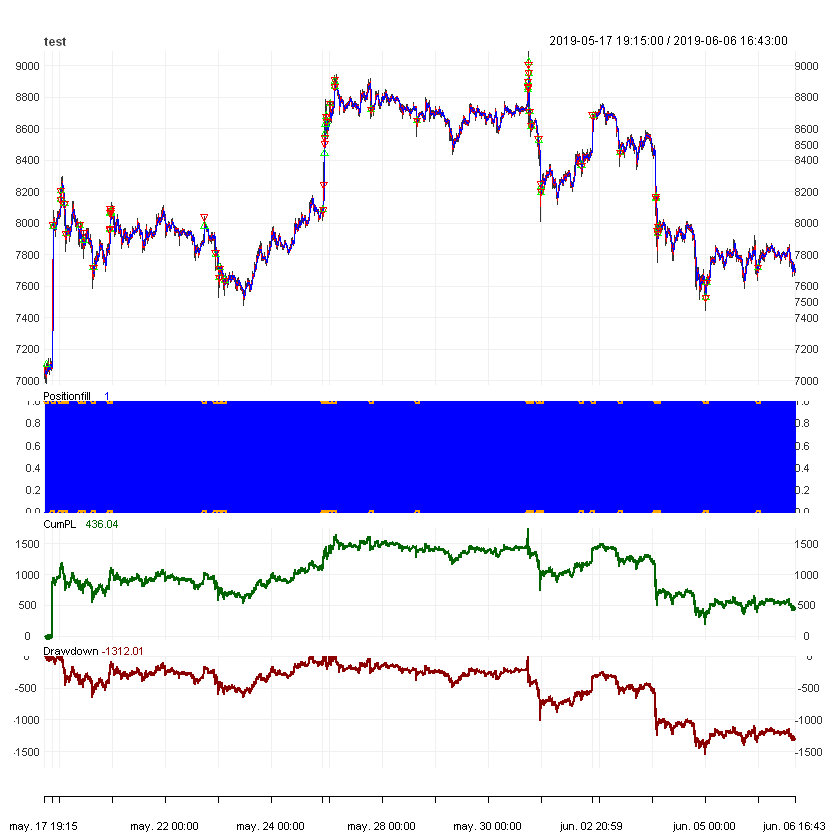

In [37]:
# Plot the performance of the strategy

chart.Posn(portfolio.st, Symbol = "test", 
           TA="add_SMA(n = 10, col = 2); add_SMA(n = 30, col = 4)")

In [38]:
# Print out the performance of the strategy over the testing period.

data.frame(round(t(tradeStats(portfolio.st)[-c(1,2)]),2))

,test
Num.Txns,101.00
Num.Trades,50.00
Net.Trading.PL,436.04
Avg.Trade.PL,9.66
Med.Trade.PL,-7.65
Largest.Winner,885.84
Largest.Loser,-451.64
Gross.Profits,3701.87
Gross.Losses,-3219.01
Std.Dev.Trade.PL,205.51
